<a href="https://colab.research.google.com/github/nrodas1999/X.C51/blob/main/pset1_Frida_Nicole_Angehrn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  <center> Problem Set 1 (MHC) <center>
<center> Spring 2025 <center>
<center> 3.C01/3.C51, 7.C01/7.C51, 10.C01/10.C51, 20.C01/20.C51 <center>
<center> Due: Monday, April 7, 2025 at 3:00 PM ET. <center>

<b>Name: Frida Nicole Angehrn Rodas</b>

<b>Kerberos ID: 900791089 </b>

### Instructions:

Put your code in the code blocks flagged with `############# Code ##########`.

Numerical answers yielded from running the code should be included in an Answer Block (see next cell).

We have provided print statements where numerical answers are expected.

Your answer should be contained in a variable which you defined either in the Answer Block or the Code Block.

When a qualitative answer is expected, place those comments as Markdown/Text cells; when asked for within Code blocks, you can write answer as code comments by placing a # before your answer.

Your Answer Block should look like the following:

In [ ]:
########## Answer ############

ans = 2
print("My answer is: {}.".format(ans))

# My regressor over-fitted the training data, I need to add regularization

########## Answer ############

My answer is: 2.


## Imports

In [ ]:
# import packages
import numpy as np
import sklearn
import pandas as pd
from sklearn.model_selection import train_test_split

# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F

# metrics
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter("ignore", category=ConvergenceWarning)
import torch
from tqdm import tqdm


# plotting style, you can choose your own parameters
import matplotlib

matplotlib.rcParams.update({'font.size': 15})
matplotlib.rc('lines', linewidth=3, color='g')
matplotlib.rcParams['axes.linewidth'] = 2.0
matplotlib.rcParams['axes.linewidth'] = 2.0
matplotlib.rcParams["xtick.major.size"] = 6
matplotlib.rcParams["ytick.major.size"] = 6
matplotlib.rcParams["ytick.major.width"] = 2
matplotlib.rcParams["xtick.major.width"] = 2
matplotlib.rcParams['text.usetex'] = False

In [ ]:
# A helper function for students to produce plots
def plot_clf(model, X, y, title):

    '''
        A function to plot confusion matrix and ROC curve

        Args:
            model(classifier object): model object (e.g. RandomForestClassifier, LogisticRegression)
            X(np.array): feature set
            y(np.array): label set
            title(str): plot name

        Example Usage:
            plot_clf(model, X_test, y_test, "test")
    '''

    fig, [ax_roc, ax_conf] = plt.subplots(1, 2, figsize=(12, 6))
    fig.tight_layout()

    RocCurveDisplay.from_estimator(model, X, y, ax=ax_roc)
    ConfusionMatrixDisplay.from_estimator(model, X, y, ax=ax_conf)

    ax_roc.set_title('{} ROC'.format(title))
    ax_conf.set_title('{} Confusion Matrix'.format(title))

    plt.show()

## Grading guideline

- Didn't answer the question 0%
- Showed some attempts, but clearly didn't try enough: 25%
- Showed solid attempts (showed code) but does not answer the question directly: 50%
- Showed solid attempts and get the question wrong: 60-80%
- Showed solid attempts with some small mistakes: 80-90%
- Showed code and answered the questions correctly: 100%

# Overview:
In this PSET, you will:

* Learn the basics of processing your data and training a machine learning model with PyTorch:
    * Processing data, including exploring OHE vs. other featurization techniques
    * Formatting your data into a `Dataset` object and wrapping in a `DataLoader` instance
    * Implementation of a Multi-Layer Perception in `PyTorch`
    * Setting up a training and testing loop, and how to do evaluation
    * Using a GPU to accelerate training!
    * Find the best hyperparameters


* Learn how to build some simple architectures for **classification** and **regression**:
    * Train a logistic regression model with `scikit-learn` to _classify_ breast cancers based on metabolite abundance
    *  Train a random forest classifier on the same data
    * Train a MLP using `PyTorch` on the same data
    * Train a MLP with `PyTorch` to _regress_ binding affinities of antibodies from their sequences
    * Apply regularization techniques to avoid overfitting (L1 and L2)
    * Apply physical descriptor-based encoding to improve training performance


## Download required data

In [ ]:
# for 1st set of tasks: binary classification
# TODO: update the datapaths
! wget https://raw.githubusercontent.com/coleygroup/ML4MolEng/main/psets/ps1-bio/data/breastcancer_X.csv
! wget https://raw.githubusercontent.com/coleygroup/ML4MolEng/main/psets/ps1-bio/data/breastcancer_y.csv

# for 2nd set of tasks: regression of binding affinities
! wget https://raw.githubusercontent.com/coleygroup/ML4MolEng/main/psets/ps1-bio/data/data_mhc/amino_acid.csv
! wget https://raw.githubusercontent.com/coleygroup/ML4MolEng/main/psets/ps1-bio/data/data_mhc/ba_train.csv
! wget https://raw.githubusercontent.com/coleygroup/ML4MolEng/main/psets/ps1-bio/data/data_mhc/ba_holdout.csv
! wget https://raw.githubusercontent.com/coleygroup/ML4MolEng/main/psets/ps1-bio/data/data_mhc/amino_acids.npy

--2025-04-05 03:35:44--  https://raw.githubusercontent.com/coleygroup/ML4MolEng/main/psets/ps1-bio/data/breastcancer_X.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 469363 (458K) [text/plain]
Saving to: ‘breastcancer_X.csv.2’

breastcancer_X.csv. 100%[===================>] 458.36K  --.-KB/s    in 0.004s  

2025-04-05 03:35:44 (105 MB/s) - ‘breastcancer_X.csv.2’ saved [469363/469363]

--2025-04-05 03:35:45--  https://raw.githubusercontent.com/coleygroup/ML4MolEng/main/psets/ps1-bio/data/breastcancer_y.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting

# Problem 1: Breast cancer classification from metabolite data

## 1.1 (5 points) Load and inspect the raw data

We have provided the code to load the dataset. Take a moment to understand what each line is doing. Briefly explain what each line of the code is doing by providing short comments below.

You will have to do it by yourself again in Problem 2.

In [ ]:
p1_X = pd.read_csv("./breastcancer_X.csv", header='infer', index_col=0) # This uses pandas (pd) to load the breast cancer X data we downloaded before and assign it as p1_X
# header='infer' is so that pandas automatically figures what the headers are, in this case the metabolites
#index_col=0 makes the first column be the row index, so basically every patient is an index.
p1_y = pd.read_csv("./breastcancer_y.csv", header='infer', index_col=0) # Same but for y, only difference is the headers here are only diagnosis and sample.

metabolite_name = p1_X.columns.tolist() # This makes a vector with the titles of each column which are the metabolites. So basically whatever header='infer' detected as headers for each column

p1_X = p1_X.values # This saves p1_X as only the values, in an array that I am guessing is a matrix with the rows and numbers we had before
p1_y = p1_y.values # Same for y, I am guessing here we only get one vector.

#through this process we lost the patient id's but I am guessing that is fine because they have the same order in both data frames?
#we also lost the header in y but we don't need it because it is only one vector
#we saved the metabolite names for later in the second step :)

Report how many examples are in this dataset and the number of features for each data point.

In [ ]:
########## Answer ############
N_samples = p1_X.shape[0] #number of patients aka. num of rows in p1_X or p1_Y
N_features = p1_X.shape[1] #number of matbolites aka. length of metabolite_name or number of columns in p1_X
print("There are {} samples.".format(N_samples))
print("There are {} features per sample.".format(N_features))

########## Answer ############

There are 211 samples.
There are 128 features per sample.


## 1.2 (5 points) Generate train/test splits.
Generate and print the shapes of your four variables, `X_train`, `X_test`, `y_train`, and `y_test`, and ensure sure that the dimensions match your expectations.

In [ ]:
########### Code #############
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    p1_X, p1_y, test_size=0.20)
########### Code #############

In [ ]:
########## Answer ############

X_train_shape = X_train.shape
y_train_shape = y_train.shape
X_test_shape = X_test.shape
y_test_shape = y_test.shape


print("X_train shape: {}".format(X_train_shape))
print("y_train shape: {}".format(y_train_shape))

print("X_test shape: {}".format(X_test_shape))
print("y_test shape: {}".format(y_test_shape))
#the dimensions are correct 0.8*211 = 168.8 I don't know why it rounds it down but the split 168 and 43 does add up to 211

########## Answer ############

X_train shape: (168, 128)
y_train shape: (168, 1)
X_test shape: (43, 128)
y_test shape: (43, 1)


## 1.3 (5 points) Preprocess the data through scaling
Scale the dataset.

In [ ]:
########### Code #############
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

X_test_scaled = scaler.transform(X_test)

########### Code #############

Print the mean/variance for each transformed feature.

In [ ]:
########## Answer ############

train_mean = X_train_scaled.mean(0)
train_variance = X_train_scaled.std(0) ** 2

test_mean = X_test_scaled.mean(0)
test_variance = X_test_scaled.std(0) ** 2

print("The means of the transformed feature train set are {}".format(train_mean))
print("The variances of the transformed feature train set are {}".format(train_variance))
print("The means of the transformed feature test set are {}".format(test_mean))
print("The variances of the transformed feature test set are {}".format(test_variance))
#the means for training are on the -15 or -16 order and not exactly 0, probably floating point error
#the means and standard deviation of test are of course not 0 or 1 because the fit was only done on training set
#importance discussed below
########## Answer ############

The means of the transformed feature train set are [ 2.11603222e-15  7.57661130e-16  6.32761039e-16  9.78053617e-16
  7.81121199e-16  6.00049111e-16  6.89924308e-16 -4.99600361e-16
 -4.36819892e-16 -3.99151611e-16  4.39463281e-16  4.70523091e-16
 -2.40878746e-16  8.18128634e-16 -7.00497861e-16  8.48527597e-16
 -4.31533116e-16 -1.28386058e-15 -2.36418028e-16  6.86620073e-16
 -2.48808910e-16 -5.86171323e-16  1.08246745e-15 -1.05405103e-15
 -3.56857401e-17  9.70784300e-16 -1.12343997e-17 -1.01770444e-16
 -4.67879703e-16 -6.59525344e-16 -3.10598108e-17  4.51688951e-16
  1.86358865e-15 -2.54426110e-16  8.35971504e-17  7.83764588e-16
 -3.15884884e-16 -3.03989638e-17  3.99151611e-16 -3.27119284e-16
  1.78296531e-15  2.00897500e-16  5.14799843e-16  3.17867426e-16
 -1.59924983e-16  4.67879703e-16 -9.29150936e-16  9.51950159e-16
 -8.65709620e-17 -4.51688951e-16  2.56408651e-16 -3.93203988e-17
  6.10622664e-16 -9.21385983e-16 -7.40809530e-16  3.68752647e-16
 -2.00897500e-16  2.90772697e-17  3.951


Q: Discuss the importance of not fitting the scaler transform on both train & test; why the transformed mean / variance between X_test_scaled & X_train_scaled may not be the same; and why this difference is potentially heartening.

A: To my understanding the whole point of doing train/test splits is to keep the test part hidden from our model until we actually test it. This is in order to simulate a real life scenario. If we let our model look into the test data and statistically fit it we will get better results (due to bias) so they won't represent the actual functionality of our model.
We want our data from training and test to be different so we get a good sense of our model working well in real life scenarios, so a difference in mu and sigma is good. 🙂

## 1.4 (10 points) Training a logistic regression classifier with `scikit-learn`

`scikit-learn` has many handy simple machine learning frameworks that make it relatively simple to train, cross-validate, and tune a machine learning model that does not need to be heavily customized.


Below, train and evaluate a Logistic Regression model.

In [ ]:
########### Code #############
clf = LogisticRegression().fit(X_train_scaled, y_train.ravel())
y_train_proba = clf.predict_proba(X_train_scaled)[:,1]
train_auc = roc_auc_score(y_train, y_train_proba)

y_test_proba = clf.predict_proba(X_test_scaled)[:,1]
test_auc = roc_auc_score(y_test, y_test_proba)

########### Code #############

Report the AUC for both the train and test datasets.

In [ ]:
########## Answer ############

print("The training AUC score is {:.3f}".format(train_auc) )
print("The testing AUC score is {:.3f}".format(test_auc) )
#It is a good sign that train has a lower AUC because it means that the model is not learning from the test data

########## Answer ############

The training AUC score is 1.000
The testing AUC score is 0.997


Generate plots for the confusion matrices and the ROC curve for both training and testing. Please use the `plot_clf` function defined above.

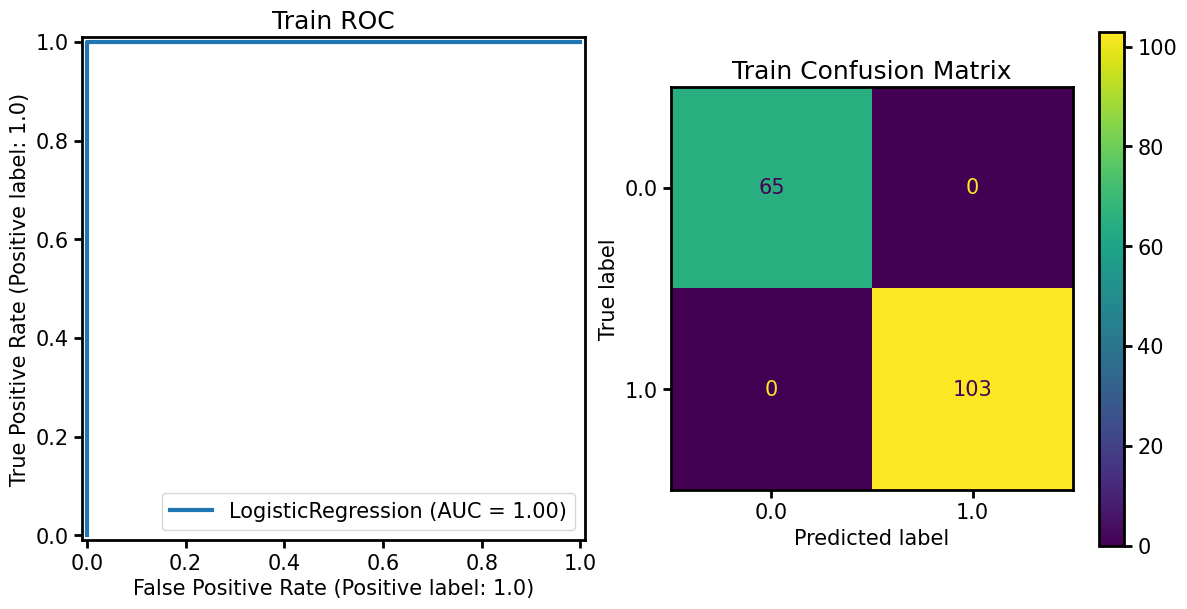

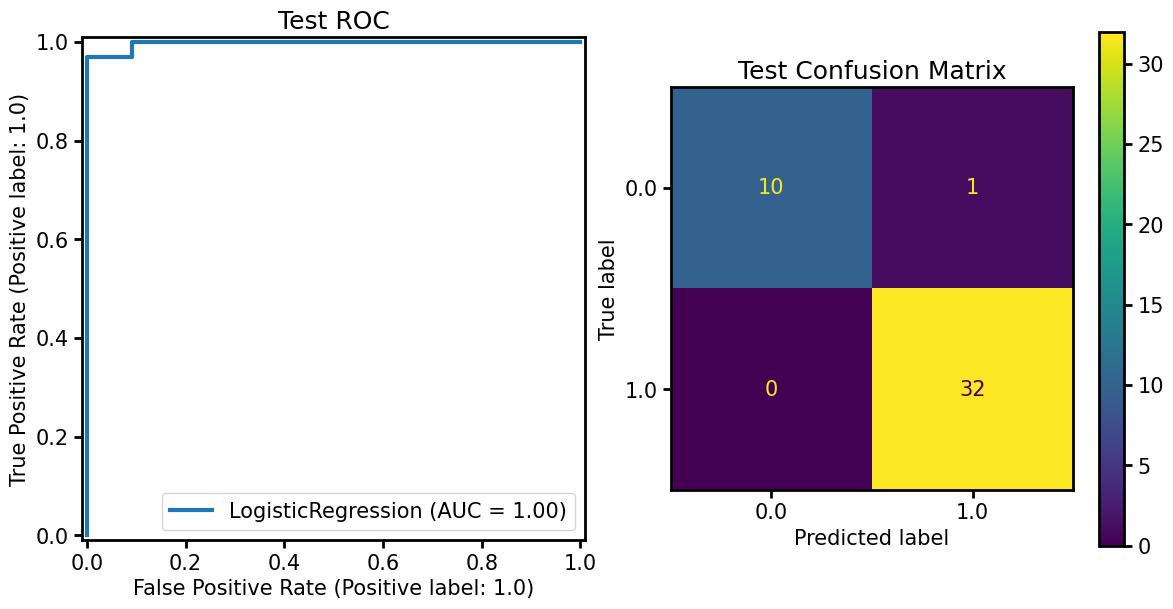

In [ ]:
########### Code #############
plot_clf(clf, X_train_scaled, y_train, "Train")
plot_clf(clf, X_test_scaled, y_test, "Test")
########### Code #############

Generate a plot of the model coefficients' distribution using `plt.hist`.

(array([ 2.,  3.,  6., 13., 26., 39., 25.,  7.,  3.,  4.]),
 array([-0.68257071, -0.55455147, -0.42653223, -0.29851298, -0.17049374,
        -0.0424745 ,  0.08554475,  0.21356399,  0.34158323,  0.46960248,
         0.59762172]),
 <BarContainer object of 10 artists>)

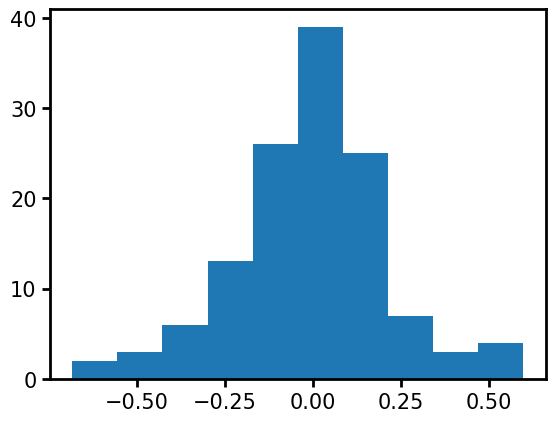

In [ ]:
########### Code #############
coef = clf.coef_
matplotlib.pyplot.hist(coef.flatten(), bins=10)

########### Code #############

## 1.5 (5 points) Introduce L1 regularization
Modify the LogisticRegression call made to run L1-regularized logistic regression.

In [ ]:
########### Code #############
clf_l1= LogisticRegression(penalty='l1', solver='saga').fit(X_train_scaled, y_train.ravel())
y_train_proba_l1 = clf_l1.predict_proba(X_train_scaled)[:,1]
train_auc = roc_auc_score(y_train, y_train_proba)

y_test_proba = clf_l1.predict_proba(X_test_scaled)[:,1]
test_auc = roc_auc_score(y_test, y_test_proba)
########### Code #############

Report the ROC-AUC score.

In [ ]:
########## Answer ############

print("The training AUC score is {:.2f}".format(train_auc) )
print("The testing AUC score is {:.2f}".format(test_auc) )

########## Answer ############

The training AUC score is 1.00
The testing AUC score is 1.00


Correspondingly, generate the new confusion matrix and ROC curve.

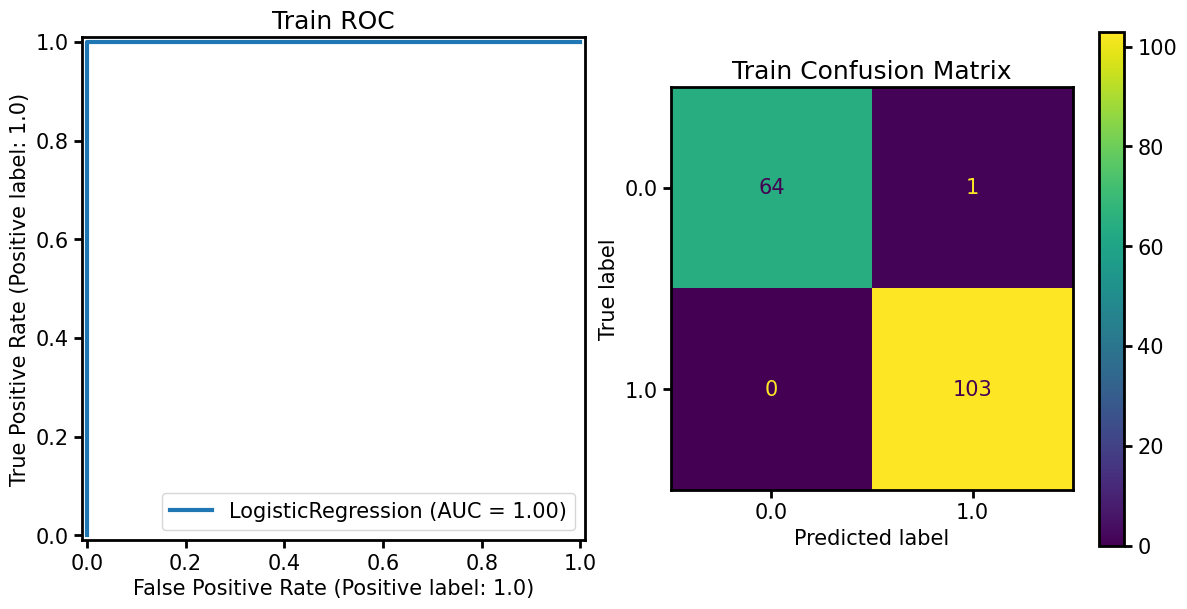

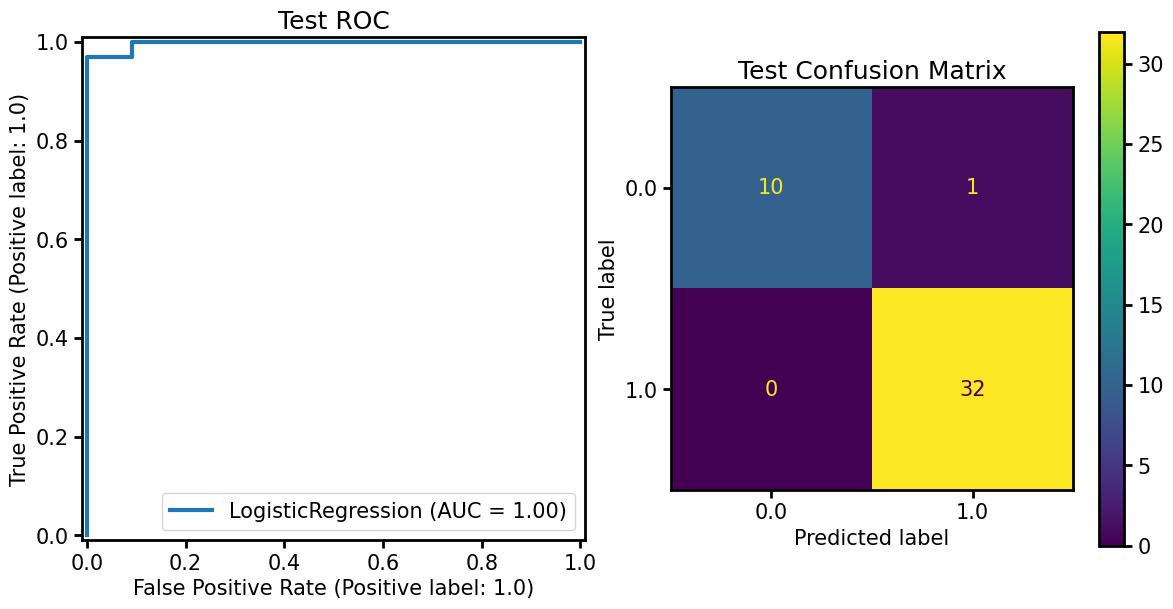

In [ ]:
########### Code #############
plot_clf(clf_l1, X_train_scaled, y_train, "Train")
plot_clf(clf_l1, X_test_scaled, y_test, "Test")
########### Code #############

Plot the new distribution of model coefficients.

(array([ 3.,  1.,  3.,  5.,  6., 99.,  4.,  3.,  2.,  2.]),
 array([-0.74654539, -0.60045496, -0.45436453, -0.30827411, -0.16218368,
        -0.01609325,  0.12999717,  0.2760876 ,  0.42217802,  0.56826845,
         0.71435888]),
 <BarContainer object of 10 artists>)

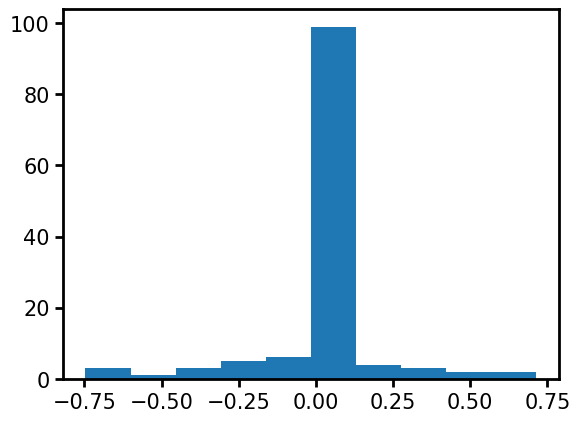

In [ ]:
########### Code #############
coef_l1 = clf_l1.coef_
matplotlib.pyplot.hist(coef_l1.flatten(), bins=10)
########### Code #############

Comment on the histogram you obtained, by comparing it to the one generated from the unregularized model's coefficients.

When using l1 we get way more coeffiecients equal to 0. This could mean there is less overfitting due to the regularization we are using so the coefficients we see in the l1 model work better in unseen data and are more reliable for deciding what metabolites are playing a role in breast cancer

## 1.6  (optional +2.5 points) Connect model coefficients back to metabolites

Code to identify the top 5 metabolites that positively correlated the most with positive diagnosis.

In [ ]:
########### Code #############
metabolite_coef = pd.DataFrame({'Metabolite': metabolite_name, 'Coefficient': coef_l1.flatten()})
metabolite_coef['Absolute Values'] = metabolite_coef['Coefficient'].abs()
top_metabolites = metabolite_coef.nlargest(5, 'Absolute Values')
metabolites = top_metabolites['Metabolite'].tolist()

########### Code #############

Report the metabolites you identified.

In [ ]:
########## Answer ############

print("The top 5 metabolites are {}".format(", ".join(metabolites)) )

########## Answer ############

The top 5 metabolites are 2,3'-Dipyridyl, 2-Butenedioic acid, 2-oxo-3-methyl-pentanoic acid, 2-hydroxypyridine, 1,2-dimethylpropanol


## 1.7 (5 points) Hyperparameter tuning the regularization parameter
Scan over the following regularization values `C=[0.01, 1, 5, 10]` (in `scikit-learn`, the regularization parameter `C` is inversely related to the regularization strength) and report which one yields the best performance (with the AUROC metric) on the train dataset. What is its performance on the test data?

In [ ]:
########### Code #############

best_value = None
best_metric = 0
C_values = [0.01, 1, 5, 10]
for c in C_values:
  clf_C_scan = LogisticRegression(C=c)
  clf_C_scan.fit(X_train_scaled, y_train.ravel())
  y_C_val_proba = clf_C_scan.predict_proba(X_test_scaled)[:,1]
  y_C_val_auc = roc_auc_score(y_test.ravel(),y_C_val_proba)
  if y_C_val_auc > best_metric:
    best_metric = y_C_val_auc
    best_value = c
test_auc = best_metric

########### Code #############

In [ ]:
########### Answer #############

print(f"Best value: C = {best_value}")
# Performance on test AUC:
print("The hyperparameterized model's test AUC score is {:.2f}".format(test_auc) )

########### Answer #############

Best value: C = 0.01
The hyperparameterized model's test AUC score is 1.00


Best value: C = 5
The hyperparameterized model's test AUC score is 0.97

## 1.8 (5 points) Training a random forest classifier with `scikit-learn`

To minimize the variance of our method to reduce error arising from epistemic error (that is, from a set of limited data), we may often look to train multiple copies of a machine learning model, i.e., an _ensemble_ machine learning method.

Here, train a Random Forest classifier, which is an ensemble of decision trees. Random Forests, empirically, work really well on tabular data, but can be known to overfit easily. To mitigate this concern, also perform cross validation.

In [ ]:
########### Code #############
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score


scaler = preprocessing.StandardScaler()
model = sklearn.ensemble.RandomForestClassifier(max_depth=2, n_estimators=20)
pipeline = Pipeline([('scaler', scaler), ('model', model)])

# Now call cross_val_score() and feed it: your pipeline as the estimator
# and your data (p1_X & p1_y) letting cross_val_score() handle the test / train split for you.
cv_scores = cross_val_score(pipeline, p1_X, p1_y.ravel())
mean = np.mean(cv_scores)
std = np.std(cv_scores)
########### Code #############

Report the cross-validated ROC-AUC score.

In [ ]:
########## Answer ############


print("The mean of CV scores is {:.2f}".format(mean) )
print("The std of CV scores is {:.2f}".format(std) )

########## Answer ############

The mean of CV scores is 0.95
The std of CV scores is 0.04


# Problem 2: Training a Multi-Layer Perceptron (MLP) to predict binding affinities
## 2.1: (5 points) Encoding the data

For this second task, we will utilize peptide sequence data to predict their binding affinities. Before we can build a model, we need to process the data by one-hot encoding the peptides based on their amino acids.

Generate the X matrix and y vector from processing `binding_df_train` and `binding_df_test` appropriately (do not run any inference on `binding_df_test` until Part 2.5, but it's helpful to process it the same way here for consistency). Hint: Note that the one-hot encoding we perform should still give us a 2D matrix of `n_samples` x `n_features`, but now `n_features` will be different from the number of features originally.

In [ ]:
from re import X
binding_df_train = pd.read_csv("ba_train.csv",header='infer', index_col=0) # Read in the dataset
binding_df_test = pd.read_csv("ba_holdout.csv",header='infer', index_col=0) # Read in the holdout dataset
amino_acids = np.load('amino_acids.npy') # Read all amino acids

# Your code to featurize amino acids
########### Code #############

train_peptides = binding_df_train['Peptide']
y_train = binding_df_train['Binding Affinity'].values
test_peptides = binding_df_test['Peptide']
y_test = binding_df_test['Binding Affinity'].values

def one_hot_encode(peptide_series, amino_acids):
       lb = preprocessing.LabelBinarizer()
       lb.fit(amino_acids)
       encoded_peptides = []
       for peptide in peptide_series:
           encoded_peptide = []
           for amino_acid in peptide:
               encoded_aa = lb.transform([amino_acid])  # Encode single amino acid
               encoded_peptide.append(encoded_aa)
           encoded_peptides.append(np.concatenate(encoded_peptide)) # Concatenate along axis 0
       return np.array(encoded_peptides)

X_train = one_hot_encode(train_peptides, amino_acids)
print(X_train.shape)
X_test = one_hot_encode(test_peptides, amino_acids)
print(X_test.shape)

N_samples = X_train.shape[0]
N_features = X_train.shape[1]
N_feat_vals = X_train.shape[2]

########### Code #############

(1226, 9, 20)
(232, 9, 20)


Report the number of samples, number of features, and the number of possible values for one (not yet one-hot-encoded) feature you might have.

In [ ]:
########## Answer ############

print("There are {} samples.".format(N_samples))
print("There are {} features per sample.".format(N_features))
print("There are {} possible values for one feature.".format(N_feat_vals))

########## Answer ############

There are 1226 samples.
There are 9 features per sample.
There are 20 possible values for one feature.


## Check GPU usage

In [ ]:
# Check if your GPU is requested successfully or not
assert torch.cuda.device_count() != 0

To work with GPU-accelerated training, we need to use `PyTorch`'s `Tensor` objects, which can help us manage CPU vs. GPU usage.

Demonstrate moving this sample tensor to and from the GPU.

In [ ]:
numpy_sample = np.zeros((3, 5))
tensor_sample = torch.Tensor(numpy_sample)
print(tensor_sample.device)

###
tensor_sample = tensor_sample.to('cuda')
print(tensor_sample.device)
tensor_sample = tensor_sample.to('cpu')
print(tensor_sample.device)

###

cpu
cuda:0
cpu


## Build Datasets and DataLoaders in PyTorch

Below, we provide you with an example of a `Dataset` instance, the `SequenceDataset` class, to format your data.

Note that tensors are not moved onto the GPU at initialization or inside `__getitem__`; GPU memory is typically far more limited than CPU-available memory. To prevent out-of-memory errors, we typically minimize the amount of data on the GPU at any time. During `.forward()`, the easiest way to do this is by only putting one batch at a time on the GPU.

In [ ]:
# Generate dataset
class SequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.Tensor(np.array(X))  # store X as a pytorch Tensor
        self.y = torch.Tensor(np.array(y))  # store y as a pytorch Tensor
        self.len=len(self.X)                # number of samples in the data

    def __getitem__(self, index):
        return self.X[index], self.y[index] # get the appropriate item

    def __len__(self):
        return self.len

Now, we use the `Dataset` object to make train, validation, and test `SequenceDataset` objects, then wrap each in a `DataLoader` object. Here are some handy arguments you can use to format your `DataLoader`:
* `batch_size`: the number of examples that your model will see in one minibatch during one forward/backward call.
* `shuffle`: whether or not to shuffle your data between epochs; if it is set to True, then each epoch's batches will be different in identity (training should always have this set to True; for debugging or other reasons, you may wish to also have it true for validation and or test).
* `num_workers`: useful for when you have a lot of data to load in when making a batch; this allows you to multiprocess batch formation before they are executed on the GPU. it won't make much difference in this homework, but can be handy down the line :)

In [ ]:
# Generate train/val splits and make dataloaders
X_subtrain, X_val, y_subtrain, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
train_data = SequenceDataset(X_subtrain, y_subtrain)
val_data = SequenceDataset(X_val, y_val)
test_data = SequenceDataset(X_test, y_test)

batch_size = 128
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

Run this cell to check that the DataLoaders work as expected.

In [ ]:
# Check data shapes
for loader in [train_dataloader, val_dataloader, test_dataloader]:
    for index, batch in enumerate(loader):
        # Your batch returns a X, y stacked in a batch
        X_batch, y_batch = batch[0], batch[1]
        print(X_batch.shape, y_batch.shape)
    print()

torch.Size([128, 9, 20]) torch.Size([128])
torch.Size([128, 9, 20]) torch.Size([128])
torch.Size([128, 9, 20]) torch.Size([128])
torch.Size([128, 9, 20]) torch.Size([128])
torch.Size([128, 9, 20]) torch.Size([128])
torch.Size([128, 9, 20]) torch.Size([128])
torch.Size([128, 9, 20]) torch.Size([128])
torch.Size([84, 9, 20]) torch.Size([84])

torch.Size([128, 9, 20]) torch.Size([128])
torch.Size([118, 9, 20]) torch.Size([118])

torch.Size([128, 9, 20]) torch.Size([128])
torch.Size([104, 9, 20]) torch.Size([104])



There should be 8 training set batches (with one partial train set batch), 2 validation batches, and 2 test batches, with sizes shown above.

## 2.2 (10 points) Define the MLP in PyTorch

Look at the following code snippet to understand how the linear layer works in PyTorch. Take careful note of the dimensions of the input and output.

In [ ]:
linear = torch.nn.Linear(2, 3)

input_tensor = torch.ones((4, 2))
output_tensor = linear(input_tensor)

print(input_tensor, output_tensor, input_tensor.shape, output_tensor.shape)

tensor([[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]]) tensor([[ 0.1455, -1.1403,  1.1924],
        [ 0.1455, -1.1403,  1.1924],
        [ 0.1455, -1.1403,  1.1924],
        [ 0.1455, -1.1403,  1.1924]], grad_fn=<AddmmBackward0>) torch.Size([4, 2]) torch.Size([4, 3])


Look at the following code snippet to understand how the ReLU layer works in PyTorch (the Tanh layer is similar). Take careful note of the dimensions of the input and output.

In [ ]:
relu = torch.nn.ReLU()

input_tensor = torch.ones((4, 2))
output_tensor = relu(input_tensor)

print(input_tensor, output_tensor, input_tensor.shape, output_tensor.shape)

tensor([[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]]) tensor([[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]]) torch.Size([4, 2]) torch.Size([4, 2])


Look at the following code snippet to understand how to stack layers with the Sequential module.

In [ ]:
layer1 = torch.nn.Linear(2, 3)
layer2 = torch.nn.Linear(3, 4)

sequential = torch.nn.Sequential(layer1, layer2)

input_tensor = torch.ones((5, 2))
output_tensor = sequential(input_tensor)

print(input_tensor, output_tensor, input_tensor.shape, output_tensor.shape)

tensor([[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]]) tensor([[0.1737, 0.4947, 0.2932, 0.8474],
        [0.1737, 0.4947, 0.2932, 0.8474],
        [0.1737, 0.4947, 0.2932, 0.8474],
        [0.1737, 0.4947, 0.2932, 0.8474],
        [0.1737, 0.4947, 0.2932, 0.8474]], grad_fn=<AddmmBackward0>) torch.Size([5, 2]) torch.Size([5, 4])


Build your MLP within the following torch.nn.Module object.

In [ ]:
########### Code #############
class BindingMLP(torch.nn.Module):
    def __init__(self, in_features=None, layers=None, activation=None):
        # You may either modify the above __init__ call to either take in hyperparameters as keyword arguments,
        # or hard-code them below. If you want to do hyperparameter search, then modifying to take in
        # keyword arguments is recommended.
        super().__init__()

        ########### Code #############

        # Implement your code here
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(in_features, 512)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(512, 256)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(256, 128)
        self.relu3 = nn.ReLU()
        self.linear_out = nn.Linear(128, 1)

        self.model = nn.Sequential(
            self.flatten,
            self.linear1,
            self.relu1,
            self.linear2,
            self.relu2,
            self.linear3,
            self.relu3,
            self.linear_out
        )

        ########### Code #############

    def forward(self, x):
        x = self.model(x)

        return x

########### Code #############

## 2.3 (10 points) Implement functions for training and testing

We define your device, model, and epochs; fill in the optimizer and loss function. For the optimizer, use an L2 weight of 0.01 and the Adam optimizer.

In [ ]:
########### Code #############

# device to train on
device = 'cuda:0'
# define your model
model = BindingMLP(in_features=180).to(device)

# define your optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3,weight_decay=0.01)
# define your loss function
loss_fn = torch.nn.MSELoss()

# define number of epochs
epochs = 250

########### Code #############

Implement your training and validation loops here.
Important hint for `MSELoss()`: make sure your inputs are the **same shape**! You might see unhelpful predictions in your scatterplot otherwise. Consider using `.view_as(arg)` or `.reshape(arg)`.

In [ ]:
########### Code #############

def train(model, dataloader, optimizer, loss_fn, device):

    '''
    A function train on the entire dataset for one epoch.

    Args:
        model (torch.nn.Module): your model from before
        dataloader (torch.utils.data.DataLoader): DataLoader object for the train data
        optimizer (torch.optim.Optimizer(()): optimizer object to interface gradient calculation and optimization
        device (str): Your device (usually 'cuda:0' for your GPU)

    Returns:
        float: loss averaged over all the batches
    '''

    epoch_loss = []
    model.train() # Set model to training mode

    for batch in dataloader:
        X, y = batch
        X = X.to(device)
        y = y.to(device)

        optimizer.zero_grad() #zero grad, from 6.C51 course we learned training needs to reset gradient
        # train your model on each batch here
        y_pred = model(X) #output

        ########### Code #############
        loss = loss_fn(y_pred.flatten(), y.flatten()) #loss
        loss.backward() #backward pass
        optimizer.step() #optimizer

        epoch_loss.append(loss.item())
    epoch_mean = np.mean(epoch_loss)

        ########### Code #############

    return epoch_mean



def validate(model, dataloader, loss_fn, device):

    '''
    A function validate on the validation dataset for one epoch.

    Args:
        model (torch.nn.Module): your model for before
        dataloader (torch.utils.data.DataLoader): DataLoader object for the validation data
        device (str): Your device (usually 'cuda:0' for your GPU)

    Returns:
        float: loss averaged over all the batches

    '''

    val_loss = []
    model.eval() # Set model to evaluation mode
    with torch.no_grad():
        for batch in dataloader:
            X, y = batch
            X = X.to(device)
            y = y.to(device)

            # validate your model on each batch here
            y_pred = model(X)

            ########### Code #############
            loss = loss_fn(y_pred.squeeze(), y.squeeze())
            val_loss.append(loss.item())
    epoch_mean = np.mean(val_loss)
            #same as train but without gradient reset
            ########### Code #############


    return epoch_mean
########### Code #############

Train and validate your model.

In [ ]:
########### Code ###########
val_loss_curve = []
train_loss_curve = []

def update(progress_bar, train_loss, val_loss):
    progress_bar.set_postfix({"train_loss": train_loss, "val_loss": val_loss})

progress_bar = tqdm(range(epochs)) # this wraps your iteration in a handy progress bar to track any metrics.

for epoch in progress_bar:

    # Train your model on training data
    train_loss = train(model, train_dataloader, optimizer, loss_fn=loss_fn, device=device)

    # Validate your model on validation data
    val_loss = validate(model, val_dataloader, loss_fn=loss_fn, device=device)

    # Record train and loss performance
    train_loss_curve.append(train_loss)
    val_loss_curve.append(val_loss)

    update(progress_bar, train_loss, val_loss)
########### Code ###########

100%|██████████| 250/250 [00:07<00:00, 35.42it/s, train_loss=0.0075, val_loss=0.0272]


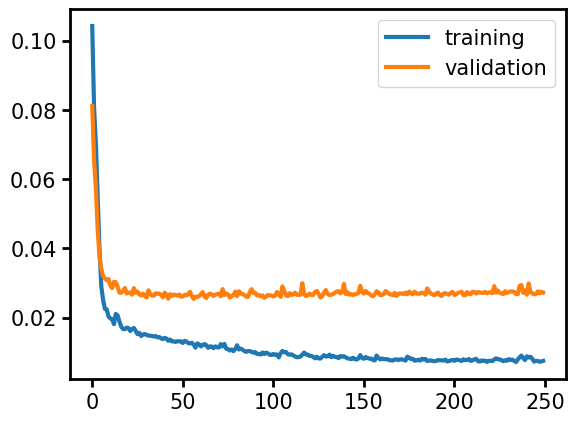

In [ ]:
plt.plot(train_loss_curve, label="training")
plt.plot(val_loss_curve, label="validation")
plt.legend()

Multi-Layer Perceptron training R^2 score: 0.92
Multi-Layer Perceptron validating R^2 score: 0.64


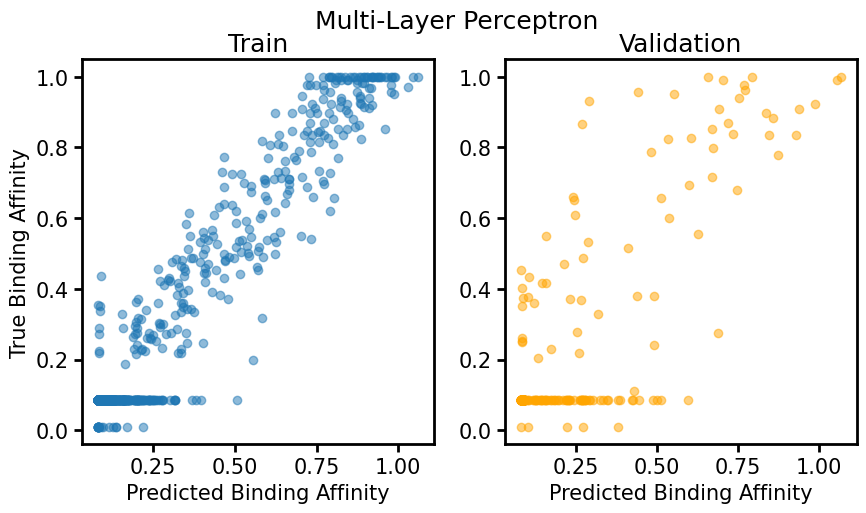

In [ ]:
########### Code #############
from sklearn.metrics import r2_score

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
X_train_tensor = torch.Tensor(X_subtrain).to(device)
yhat_train = model(X_train_tensor)
X_val_tensor = torch.Tensor(X_val).to(device)
yhat_val = model(X_val_tensor)

yhat_train = yhat_train.cpu().detach().numpy()
yhat_val = yhat_val.cpu().detach().numpy()
ax[0].scatter(yhat_train, y_subtrain, label='Train', alpha=0.5)
ax[1].scatter(yhat_val, y_val, label='Test', alpha=0.5, c='orange')

ax[0].set_ylabel("True Binding Affinity")
ax[0].set_xlabel("Predicted Binding Affinity")
ax[1].set_xlabel("Predicted Binding Affinity")
ax[0].set_title('Train')
ax[1].set_title('Validation')
fig.suptitle('Multi-Layer Perceptron')

print("Multi-Layer Perceptron training R^2 score: {:.2f}".format(r2_score(y_subtrain, yhat_train)))
print("Multi-Layer Perceptron validating R^2 score: {:.2f}".format((r2_score(y_val, yhat_val))))

########### Code #############

## 2.4 (5 points) (grad) Calculate model size

Calculate the total of number of parameters in your MLP model. What does the input hidden_layers_sizes = (512, 256, 128) mean?

In [ ]:
########## Answer ############

num_params = 180 * 512 + 512 * 256 + 256 * 128 + 128 * 1
print(f'Total number of parameters in your MLP model: {num_params:.2f}')
########## Answer ############

Total number of parameters in your MLP model: 256128.00


We have 9 features and 20 values, or in the one hot version we have 9 vectors of length 20 so we initialize with 180 inputs to the first hidden layer, then we have 3 layers each of size previous_dim*layer_dim, finally we have the output 128x1 so we have the equation above.


## 2.5 (5 points) Chemical Transferability of One-Hot Representations

MLP test R^2 score: 0.02


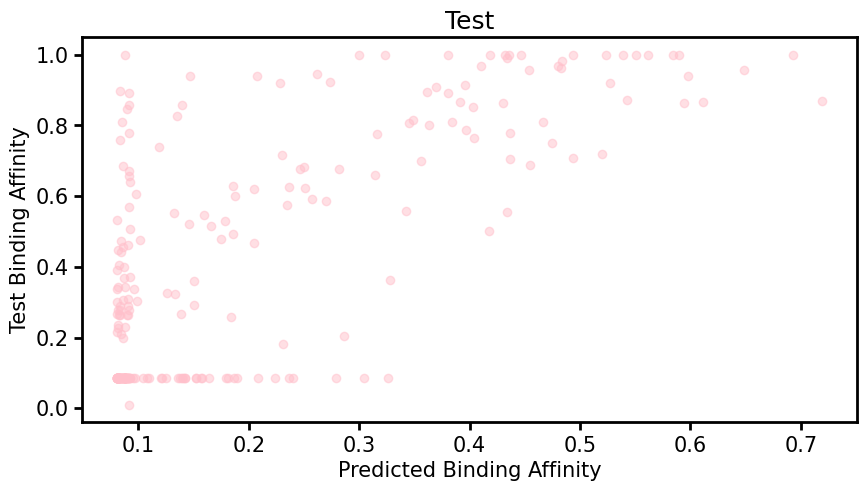

In [ ]:
########### Code #############

# Load the holdout dataset which contains amino acids not seen in the training data
#ba_holdout = pd.read_csv("ba_holdout.csv")
#I am confused because we have formatted test all along, we just haven't applied the model. I'll just do that

# Validate your model on test data
test_loss = validate(model, test_dataloader, loss_fn=loss_fn, device=device)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
X_test_tensor = torch.Tensor(X_test).to(device)
yhat_test = model(X_test_tensor)

yhat_test = yhat_test.cpu().detach().numpy()
ax.scatter(yhat_test, y_test, label='Test', alpha=0.5, c='pink')

ax.set_ylabel("Test Binding Affinity")
ax.set_xlabel("Predicted Binding Affinity")
ax.set_title('Test')

print("MLP test R^2 score: {:.2f}".format(r2_score(y_test, yhat_test)))
########### Code #############

Comment on your validation results and briefly explain.

We can clearly see a slight decrease on R2 value between training and validation data. We see a strong R2 value decrease in the test data, the model does not generalize well because the one hot method loses information of the aminoacids, one of the most substantial losses is in the order of the peptide sequence.


## 2.6 (10 points) (grad) Featurize amino acids with physical descriptors

In [ ]:
########### Code #############
amino_acid_df = pd.read_csv("amino_acid.csv")
amino_acid_df = amino_acid_df.set_index('Amino Acids')

#defining feature matrix
def feature_matrix(peptide_series, amino_acid_df):
  peptide_features = []
  for peptide in peptide_series:
      peptide_feature = []
      for aa in peptide:
          if aa in amino_acid_df.index:
              peptide_feature.extend(amino_acid_df.loc[aa].values)
      peptide_features.append(np.array(peptide_feature))
  return np.array(peptide_features)

X_train2 = feature_matrix(train_peptides, amino_acid_df)
X_test2 = feature_matrix(test_peptides, amino_acid_df)

#split train in train and val
X_subtrain2, X_val2, y_subtrain2, y_val2 = train_test_split(
    X_train2, y_train, test_size=0.20)

scaler2 = preprocessing.StandardScaler().fit(X_subtrain2)
X_subtrain2_scaled = scaler2.transform(X_subtrain2)
X_val2_scaled = scaler2.transform(X_val2)
X_test2_scaled = scaler2.transform(X_test2)

print(X_subtrain2_scaled.shape)
print(X_val2_scaled.shape)
print(X_test2_scaled.shape)



########### Code #############

(980, 675)
(246, 675)
(232, 675)


## 2.7 (10 points) (grad) Chemical transferability of Physical Descriptors

torch.Size([128, 675]) torch.Size([128])
torch.Size([128, 675]) torch.Size([128])
torch.Size([128, 675]) torch.Size([128])
torch.Size([128, 675]) torch.Size([128])
torch.Size([128, 675]) torch.Size([128])
torch.Size([128, 675]) torch.Size([128])
torch.Size([128, 675]) torch.Size([128])
torch.Size([84, 675]) torch.Size([84])

torch.Size([128, 675]) torch.Size([128])
torch.Size([118, 675]) torch.Size([118])

torch.Size([128, 675]) torch.Size([128])
torch.Size([118, 675]) torch.Size([118])

Retrained MLP Training R^2 score: 0.59
Retrained MLP Validation R^2 score: 0.63


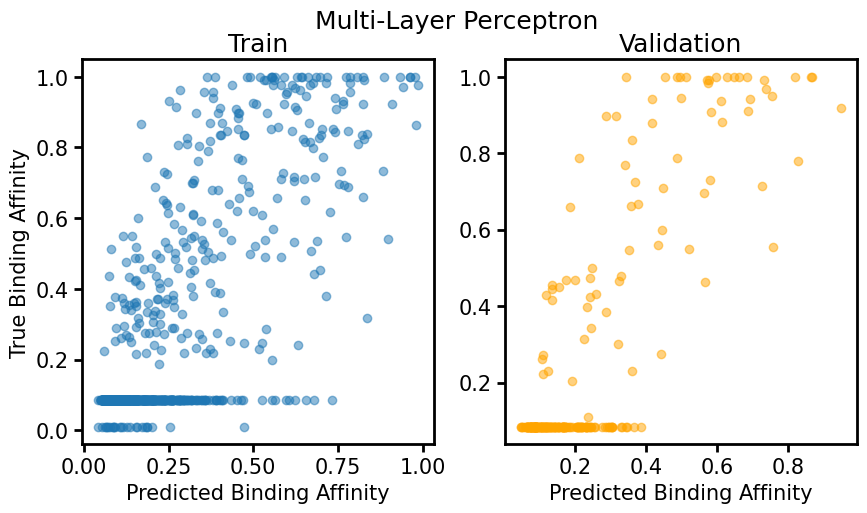

In [ ]:
########### Code #############
# new dataloaders needed
new_train_data = SequenceDataset(X_subtrain2_scaled, y_subtrain2)
new_train_dataloader = DataLoader(new_train_data, batch_size=batch_size, shuffle=True)

new_val_data = SequenceDataset(X_val2_scaled, y_val2)
new_val_dataloader = DataLoader(new_val_data, batch_size=batch_size, shuffle=True)

new_test_data = SequenceDataset(X_val2_scaled, y_val2)
new_test_dataloader = DataLoader(new_test_data, batch_size=batch_size, shuffle=True)

for loader in [new_train_dataloader, new_val_dataloader, new_test_dataloader]:
    for index, batch in enumerate(loader):
        # Your batch returns a X, y stacked in a batch
        X_batch, y_batch = batch[0], batch[1]
        print(X_batch.shape, y_batch.shape)
    print()

# device to train on
device = 'cuda:0'
# define your model
model2 = BindingMLP(in_features=675).to(device)

# define your optimizer
optimizer = torch.optim.Adam(model2.parameters(),lr=1e-3,weight_decay=0.01)
# define your loss function
loss_fn = torch.nn.MSELoss()

# define number of epochs
epochs = 250

# Train your model on training data
train_loss2 = train(model2, new_train_dataloader, optimizer, loss_fn=loss_fn, device=device)
# Validate your model on validation data
val_loss2 = validate(model2,new_val_dataloader, loss_fn=loss_fn, device=device)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
X_train_tensor2 = torch.Tensor(X_subtrain2_scaled).to(device)
yhat_train2 = model2(X_train_tensor2)
X_val_tensor2 = torch.Tensor(X_val2_scaled).to(device)
yhat_val2 = model2(X_val_tensor2)

yhat_train2 = yhat_train2.cpu().detach().numpy()
yhat_val2 = yhat_val2.cpu().detach().numpy()
ax[0].scatter(yhat_train2, y_subtrain2, label='Train', alpha=0.5)
ax[1].scatter(yhat_val2, y_val2, label='Test', alpha=0.5, c='orange')

ax[0].set_ylabel("True Binding Affinity")
ax[0].set_xlabel("Predicted Binding Affinity")
ax[1].set_xlabel("Predicted Binding Affinity")
ax[0].set_title('Train')
ax[1].set_title('Validation')
fig.suptitle('Multi-Layer Perceptron')

print("Retrained MLP Training R^2 score: {:.2f}".format(r2_score(y_subtrain2, yhat_train2)))
print("Retrained MLP Validation R^2 score: {:.2f}".format(r2_score(y_val2, yhat_val2)))

########### Code #############

MLP holdout R^2 score: 0.20


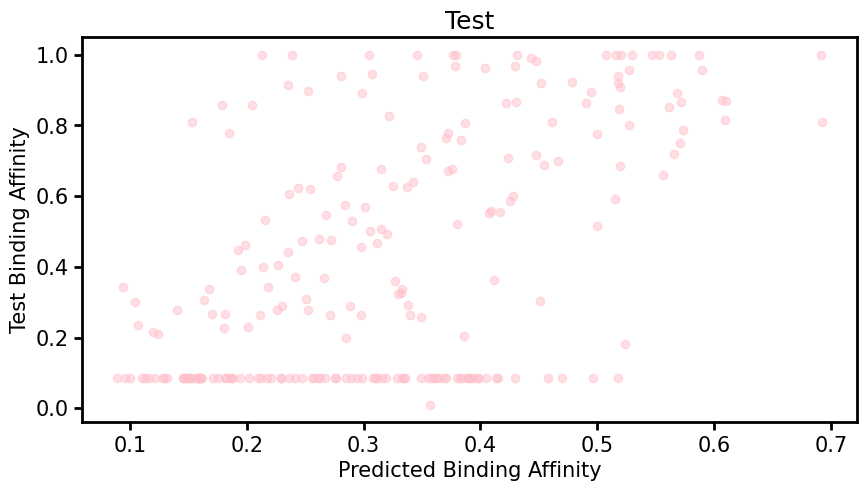

In [ ]:
########### Code #############
# Validate your model on test data
test_loss2 = validate(model2, new_test_dataloader, loss_fn=loss_fn, device=device)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
X_test_tensor2 = torch.Tensor(X_test2_scaled).to(device)
yhat_test2 = model2(X_test_tensor2)

yhat_test2 = yhat_test2.cpu().detach().numpy()
ax.scatter(yhat_test2, y_test, label='Test', alpha=0.5, c='pink')

ax.set_ylabel("Test Binding Affinity")
ax.set_xlabel("Predicted Binding Affinity")
ax.set_title('Test')

print("MLP holdout R^2 score: {:.2f}".format(r2_score(y_test, yhat_test2)))

########### Code #############

Briefly comment on your holdout performance and explain why.

This model is more complicated we see way smaller R2 for the training data than we did for the previous model. The validation data also gets affected respectively, still showing lower r2 than the train data which is a good indicator of no overfitting. Finally the test data performs better, this is because this model is probably more generalizable.

You've reached the end! Upon completing your pset, note any collaborators or assistance from AI tools in a cell below; and submit to Gradescope [here](https://www.gradescope.com/courses/1011324/assignments/6007173/).

Hi, this homework was challenging but I learned a lot. Since I am only learning python I relied heavily on gemini to parse my code, explain me code lines and sometimes help me with the implementation of classes and other python structures. Any code generated by gemini I read and analyzed extensively to make sure I learn as much as possible.
